In [1]:
from gensim.models import word2vec
import MeCab
import numpy as np
import json
import hashlib
from sklearn.cross_decomposition import CCA
from googletrans import Translator
import numpy as np
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import random
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import torch
from transformers.modeling_bert import BertModel
from transformers.tokenization_bert_japanese import BertJapaneseTokenizer
%matplotlib inline

In [2]:
translator = Translator()
mt = MeCab.Tagger('-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd/')
mt.parse('')

tokenizer = BertJapaneseTokenizer.from_pretrained('bert-base-japanese-whole-word-masking')

In [3]:
#それぞれのモデル
model_doc = Doc2Vec.load("jawiki.doc2vec.dbow300d.model")
model_word = word2vec.Word2Vec.load("wiki_plus.model")
model_bert = BertModel.from_pretrained('bert-base-japanese-whole-word-masking')

In [4]:
#word2vecのベクトル化
def get_tags(text):
    word = {}
    node = mt.parseToNode(text)
    while node:
        fields = node.feature.split(",")
        if (fields[0] == '名詞' or fields[0] == '動詞' or fields[0] == '形容詞') and node.surface in model_word.wv:
            w = node.surface
            word[w] = word.get(w, 0) + 1
        node = node.next
    return word

def weighted_mean_vec(text):
    v = np.zeros(model_word.vector_size)
    s = 1.0
    for w,weight in get_tags(text).items():
        v += weight * model_word.wv[w]  #Eventクラスeの単語wの個数＊単語wのベクトル
        s += weight
    return v / s

In [5]:
#doc2vecの分かち書き化
def get_tags_for_doc2vec(text):
    word = []
    node = mt.parseToNode(text)
    while node:
        fields = node.feature.split(",")
        if node.surface in model_doc.wv and node.surface !='':
            w = node.surface
            word.append(w)
        node = node.next
    return word

In [6]:
#bertのベクトル化
def get_vector_cls(text):
    input_ids = tokenizer.encode(text, return_tensors='pt') 
    result = model_bert(input_ids)
    tensor_result = result[0][0][0]
    numpy_result = tensor_result.to('cpu').detach().numpy().copy()
    return numpy_result

# データをデータフレーム化

In [7]:
class Event:
    def __init__(self, id, type, score, desc, links):
        self.id = id
        self.type = type
        self.score = score
        self.desc = desc
        self.links = links

In [8]:
# JSON ファイルから event set をロード
def load_events(jsonfile):
    with open(jsonfile) as f:
        df = json.load(f)
    events = {x['id']: Event(x['id'], x['type'], x['score'], x['desc'], x['links']) for x in df} #eventsにidをkeyとしそのオブジェクトをvalueとした辞書を生成
    for k,x in events.items():
        x.links = [events[e] for e in x.links] #Event.linkの中身をidの配列からEventの配列に変更
    return events

In [9]:
events = load_events('sesaku2.json')

In [10]:
import pandas as pd
data = []
labels = []
columns=[]
index=[]
for k1, v1 in events.items():
    if v1.type[-1]=='事例':
        index.append(v1.desc)

for k1, v1 in events.items():
    if v1.type[-1]=='対策':
        if not v1.desc in columns: #重複を防ぐ
            columns.append(v1.desc)

df = pd.DataFrame(index=index, columns=columns)

for k1, v1 in events.items():
    if v1.type[-1]=='事例':
        for k2, v2 in events.items():
            if v2.type[-1] == '対策':
                    if v2 in v1.links:
                        df.at[v1.desc, v2.desc] = 1
                    else:
                        df.at[v1.desc, v2.desc] = 0
df

,前機種の振り返りを実施。目標に対する達成度、課題と次の一手を適用している,会社方針と中・長期計画を基に、商品企画と製品企画を経て、目標を設定している。,社会との調和、社会への貢献実現のビジョンがある,経営責任を明確化,的確な経営判断が９０％の迅速さで下されている,社長を補佐できるキーパーソンが各部門に存在,方針管理は部門別と機能別を組み合わせたマトリックスマネジメントで管理,日常管理が各機能ごとに項目と目標が明確で、管理責任者も設定,管理目標から外れた場合のアクションが取られている,QCDの視点で、目標を設定。関連部品にも目標展開、仕様を決めた後、全体目標をアラインしている。,...,異常有無を全数検査している（外観・異音・振動等）,プランジャ当たり面の検査は、定量化・仕組み化・標準化しているか,インジェクターの色識別（品番との合致）,噴射レベルの抜き取り検査,エンジン性能の検査（トヨタ）,"機能テストは、設計指示の環境条件を満足しているか (燃料,温度,気圧 等)",インジェクターをエンジンに挿入する時の抵抗測定をする,バリ、異物有無を検査している（画像検査等）,機能検査を実施している（電流ｘ噴射量）,リーク検査を実施しているる
調査の結果、エンジンルーム内の中央左側上方付近の燃料配管のデリバリーホースから燃料が漏れ出し、引火したものと推定する。燃料漏れの原因は、販売店が中古品の燃料ポンプに交換した際に、燃料デリバリーホースの出口側のクランプの位置がずれていたとの情報から、整備不良に起因している可能性が高いものと推定する。,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
調査の結果、エンジンの排気系部品付近から焼損している状況であり、６番気筒のピストン上部（ピストンリップ）に亀裂及び穴があった。また、エンジンのオイルフィルタの取付部に液状パッキンが塗布されており、塗布された液体パッキンの一部が油路内にあった。さらに、排気系部品にオイル及びススが付着していた。以上のことから、整備時、本来、オイルフィルタ取付部に塗布しない液状パッキンが過剰に塗布され、その一部が油路内に入ったことから６番気筒のピストンをオイルで冷却するためのジェットノズルを詰まらせた。これにより、当該ピストンが過熱して穴が開き、燃焼室から漏れた燃焼ガスでエンジン内圧が上昇したことからエンジンオイルが外部に漏れ、排気系部品に付着したことによるものと推定する。,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
調査の結果、オイルフィルタブラケットの固定ボルトが緩み、Ｏリングが破断していた。Ｏリングの破断部から漏れたオイルが、排気系に付着して出火に至ったと推定する。,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
調査の結果、排気系部品付近から焼損している状況であり、エンジンのオイルフィルタにおいて、古いオイルフィルタのＯリングがフィルタ締結面に残った状態で、新しいフィルタが取り付けられていた。以上のことから、エンジンのオイルフィルタを交換する際、古いＯリングを除去せず、新しいオイルフィルタを取り付けたことによりシール不良となり、漏れたオイルが排気系部品に付着したことによるものと推定する。なお、不具合発生の１週間程前に、オイルフィルタが交換されていた。,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
調査の結果、排気系部品付近から焼損している状況であり、社外品オイルフィルタのＯリングが破損しており、当該フィルタ内部に劣化したエンジンオイルの汚れが大量に堆積していた。以上のことから、オイルフィルタが長期間使用されたことにより劣化し、Ｏリングが破損したことから漏れたエンジンオイルが排気系部品に付着したことによるものと推定する。,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
調査の結果、インジェクタハーネス及びインジェクタ根元部に焼損等が確認されたが、ハーネス及びコネクタ端子にショート等の痕跡は確認できなかった。以上のことから、何らかの外的要因により発煙に至ったものと推定するが、付近に発火源はなく原因の特定には至らなかった。なお、不具合時発生時に発生した燃料漏れは燃料戻りパイプ被熱に起因するものと推定する。,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
調査の結果、エンジン前方から焼損している状況であり、Ｖ型エンジンの右バンクの燃料配管及び燃料噴射ノズルより燃料漏れが確認された。当該車両は、２０１５年１１月にエンジン修理のため、右バンクの燃料配管が脱着されており、燃料噴射ノズルのＯリング部に組付け不良による噛み込み痕が確認された。その他、車両側に異常は認められなかった。以上のことから、燃料噴射ノズルＯリング部の組付け不良により漏れた燃料に、車両もしくは静電気等の火種が引火したものと推定する。,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
調査の結果、エンジンの排気系部品付近から焼損している状況であり、エンジンの社外品カートリッジ式オイルフィルタが緩んでおり、当該フィルタのＯリングの一部がはみ出していた。以上のことから、エンジンのオイルフィルタ取付不良により、漏れたエンジンオイルが排気系部品に付着したことによるものと推定する。,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
調査の結果、エンジンの排気系部品から焼損している状況であり、排気系部品にはエンジンオイルの付着が確認された。また、エレメント交換型エンジンオイルフィルタのOリングの取付け不良が確認された。以上のことから、車検整備時のオイルフィルタ取付け不良により漏れたオイルが排気系部品に付着して出火したものと推定する。,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
調査の結果、燃料ポンプ付近からガソリンが洩れて気化し、何らかの火花に引火したものと推定するが、原因の特定には至らなかった。,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
taisaku_vec_word = {}
for i in df:
    taisaku_vec_word[i]=weighted_mean_vec(i)

In [12]:
taisaku_vec_doc = {}
for i in df:
    taisaku_vec_doc[i]=model_doc.infer_vector(get_tags_for_doc2vec(i))

In [13]:
taisaku_vec_bert = {}
for i in df:
    taisaku_vec_bert[i]=get_vector_cls(i)

In [14]:
class Label:
    TAISAKU = 1
    NASI = 0

data_word = []
labels_word = []
# data 
for index, row in df.iterrows():#部品
    x1 = weighted_mean_vec(index)
    for i in df:#対策
        x2 =  taisaku_vec_word[i]#対策
        data_word.extend([np.append(x1, x2)])
        if row[i] ==1:
            labels_word.append(Label.TAISAKU)
        else:
            labels_word.append(Label.NASI)

In [15]:
data_doc = []
labels_doc = []
# data 
for index, row in df.iterrows():#部品
    x1 = model_doc.infer_vector(get_tags_for_doc2vec(index))
    for i in df:#対策
        x2 =  taisaku_vec_doc[i]#対策
        data_doc.extend([np.append(x1, x2)])
        if row[i] ==1:
            labels_doc.append(Label.TAISAKU)
        else:
            labels_doc.append(Label.NASI)

In [16]:
data_BERT_cls = []
labels_BERT_cls = []
# data 
for index, row in df.iterrows():#部品
    x1 = get_vector_cls(index) #部品
    for i in df:#対策
        x2=taisaku_vec_bert[i]
        data_BERT_cls.extend([np.append(x1, x2)])
        if row[i] ==1:
            labels_BERT_cls.append(Label.TAISAKU)
        else:
            labels_BERT_cls.append(Label.NASI)

In [17]:
def train_data(data,labels):
    index_1 = [i for i, x in enumerate(labels) if x == 1]
    index_0 = [i for i, x in enumerate(labels) if x == 0]
    index_0 = random.sample(index_0, len(index_1))
    data_1 = [data[i] for i in index_1]
    data_0 = [data[i] for i in index_0]
    labels = [Label.TAISAKU]*len(data_1) + [Label.NASI]*len(data_0) 
    data = data_1 + data_0
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

In [18]:
def gakusyu(data,labels):
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
    print('トレーニングデータの1の数    :',y_train.sum())
    print('トレーニングデータ1の割合    :',round(y_train.sum()/x_train.shape[0]*100,1),'%')
    print('テストデータの１の数            :',y_test.sum())
    print('テストデータの1の割合          :',round(y_test.sum()/x_test.shape[0]*100,1),'%')
    # y_train を one-hot 表現にする。
    y_train_one_hot = np_utils.to_categorical(y_train)
    y_test_one_hot = np_utils.to_categorical(y_test)
    # モデルを作成する。
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=x_train.shape[1:])) #activation
    #model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))

    model.compile(
        optimizer=Adam(lr=0.001), #最適化アルゴリズムの種類.sgd,rmsprop,adam,adagrad,nadam,adadeltaなどある。
        loss='categorical_crossentropy', #損失関数名
        metrics=['accuracy']) #訓練やテストの際にモデルを評価するための評価関数のリスト． 典型的には metrics=['accuracy']を使用する.

    # 学習を実行する。
    result = model.fit(x_train, y_train_one_hot , batch_size=16, epochs=30,validation_data=(x_test, y_test_one_hot )) #epochs 学習回数,batch_size 重みを調整の際に行う平均化のときに使うデータの数（dataの数/batch_size回）×epochs

    # 推論する。
    prob = model.predict(x_test, batch_size=len(x_test))

    # 最も確率が高いのを推定クラスとする。
    y_pred = np.argmax(prob, axis=1)

    # 精度を検証する。
    accuracy = accuracy_score(y_test, y_pred)
    print('accuracy: {:.2%}'.format(accuracy))
    return result, accuracy, model, x_test, y_test_one_hot

In [19]:
history = {'word2vec':0,'doc2vec':0,'w_count':0,'d_count':0,'bert':0,'b_count':0}
word_result = []
doc_result = []
bert_result = []

In [20]:
for i in range(5):
    data_word2, labels_word2= train_data(data_word,labels_word)
    result, accuracy, model, x_test, y_test = gakusyu(data_word2, labels_word2)
    history['word2vec'] = history['word2vec'] + accuracy
    history['w_count'] += 1
    word_result.append(result)

トレーニングデータの1の数    : 26
トレーニングデータ1の割合    : 45.6 %
テストデータの１の数            : 10
テストデータの1の割合          : 66.7 %
Epoch 1/30
4/4 [==============================] - 0s 32ms/step - loss: 0.6859 - accuracy: 0.5263 - val_loss: 0.5083 - val_accuracy: 0.6667
Epoch 2/30
4/4 [==============================] - 0s 4ms/step - loss: 0.3463 - accuracy: 0.9298 - val_loss: 0.5644 - val_accuracy: 0.6667
Epoch 3/30
4/4 [==============================] - 0s 4ms/step - loss: 0.2267 - accuracy: 0.9825 - val_loss: 0.4827 - val_accuracy: 0.6000
Epoch 4/30
4/4 [==============================] - 0s 4ms/step - loss: 0.1728 - accuracy: 0.9649 - val_loss: 0.5532 - val_accuracy: 0.6000
Epoch 5/30
4/4 [==============================] - 0s 4ms/step - loss: 0.1413 - accuracy: 0.9649 - val_loss: 0.6345 - val_accuracy: 0.6000
Epoch 6/30
4/4 [==============================] - 0s 4ms/step - loss: 0.1031 - accuracy: 0.9649 - val_loss: 0.8749 - val_accuracy: 0.6000
Epoch 7/30
4/4 [==============================] - 0s 5ms/step - lo

4/4 [==============================] - 0s 5ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.5460 - val_accuracy: 0.8000
Epoch 29/30
4/4 [==============================] - 0s 5ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.5305 - val_accuracy: 0.8667
Epoch 30/30
4/4 [==============================] - 0s 4ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.5310 - val_accuracy: 0.8667
accuracy: 86.67%
トレーニングデータの1の数    : 30
トレーニングデータ1の割合    : 52.6 %
テストデータの１の数            : 6
テストデータの1の割合          : 40.0 %
Epoch 1/30
4/4 [==============================] - 0s 24ms/step - loss: 0.7901 - accuracy: 0.4912 - val_loss: 0.5294 - val_accuracy: 0.5333
Epoch 2/30
4/4 [==============================] - 0s 5ms/step - loss: 0.3825 - accuracy: 0.8421 - val_loss: 0.5043 - val_accuracy: 0.6000
Epoch 3/30
4/4 [==============================] - 0s 4ms/step - loss: 0.2462 - accuracy: 0.8947 - val_loss: 0.5803 - val_accuracy: 0.7333
Epoch 4/30
4/4 [==============================] - 0s 5ms/st

4/4 [==============================] - 0s 4ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1191 - val_accuracy: 0.9333
Epoch 26/30
4/4 [==============================] - 0s 4ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1187 - val_accuracy: 0.9333
Epoch 27/30
4/4 [==============================] - 0s 4ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.1204 - val_accuracy: 0.9333
Epoch 28/30
4/4 [==============================] - 0s 4ms/step - loss: 9.3320e-04 - accuracy: 1.0000 - val_loss: 0.1263 - val_accuracy: 0.9333
Epoch 29/30
4/4 [==============================] - 0s 4ms/step - loss: 8.5499e-04 - accuracy: 1.0000 - val_loss: 0.1311 - val_accuracy: 0.9333
Epoch 30/30
4/4 [==============================] - 0s 4ms/step - loss: 8.0207e-04 - accuracy: 1.0000 - val_loss: 0.1346 - val_accuracy: 0.9333
accuracy: 93.33%
トレーニングデータの1の数    : 27
トレーニングデータ1の割合    : 47.4 %
テストデータの１の数            : 9
テストデータの1の割合          : 60.0 %
Epoch 1/30
4/4 [=============================

In [21]:
for i in range(5):
    data_doc2, labels_doc2 = train_data(data_doc,labels_doc)
    result, accuracy, model,x_test, y_test = gakusyu(data_doc2, labels_doc2)
    history['doc2vec'] = history['doc2vec'] + accuracy
    history['d_count'] += 1
    doc_result.append(result)

トレーニングデータの1の数    : 29
トレーニングデータ1の割合    : 50.9 %
テストデータの１の数            : 7
テストデータの1の割合          : 46.7 %
Epoch 1/30
4/4 [==============================] - 0s 25ms/step - loss: 0.7322 - accuracy: 0.4386 - val_loss: 0.6257 - val_accuracy: 0.8667
Epoch 2/30
4/4 [==============================] - 0s 5ms/step - loss: 0.6269 - accuracy: 0.7368 - val_loss: 0.6122 - val_accuracy: 0.5333
Epoch 3/30
4/4 [==============================] - 0s 5ms/step - loss: 0.5493 - accuracy: 0.7895 - val_loss: 0.5164 - val_accuracy: 0.8667
Epoch 4/30
4/4 [==============================] - 0s 5ms/step - loss: 0.4478 - accuracy: 0.9649 - val_loss: 0.4168 - val_accuracy: 0.9333
Epoch 5/30
4/4 [==============================] - 0s 5ms/step - loss: 0.3537 - accuracy: 0.9298 - val_loss: 0.3202 - val_accuracy: 0.8667
Epoch 6/30
4/4 [==============================] - 0s 5ms/step - loss: 0.2549 - accuracy: 0.9649 - val_loss: 0.2524 - val_accuracy: 0.8667
Epoch 7/30
4/4 [==============================] - 0s 4ms/step - los

4/4 [==============================] - 0s 5ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.3464 - val_accuracy: 0.9333
Epoch 24/30
4/4 [==============================] - 0s 4ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.3575 - val_accuracy: 0.9333
Epoch 25/30
4/4 [==============================] - 0s 4ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.3647 - val_accuracy: 0.9333
Epoch 26/30
4/4 [==============================] - 0s 4ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.3642 - val_accuracy: 0.9333
Epoch 27/30
4/4 [==============================] - 0s 4ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.3773 - val_accuracy: 0.9333
Epoch 28/30
4/4 [==============================] - 0s 4ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.3813 - val_accuracy: 0.9333
Epoch 29/30
4/4 [==============================] - 0s 4ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.3754 - val_accuracy: 0.9333
Epoch 30/30
4/4 [======================

4/4 [==============================] - 0s 4ms/step - loss: 0.1087 - accuracy: 1.0000 - val_loss: 0.6527 - val_accuracy: 0.6667
Epoch 10/30
4/4 [==============================] - 0s 4ms/step - loss: 0.0724 - accuracy: 1.0000 - val_loss: 0.7131 - val_accuracy: 0.6667
Epoch 11/30
4/4 [==============================] - 0s 5ms/step - loss: 0.0492 - accuracy: 1.0000 - val_loss: 0.7118 - val_accuracy: 0.6667
Epoch 12/30
4/4 [==============================] - 0s 4ms/step - loss: 0.0338 - accuracy: 1.0000 - val_loss: 0.7402 - val_accuracy: 0.7333
Epoch 13/30
4/4 [==============================] - 0s 4ms/step - loss: 0.0227 - accuracy: 1.0000 - val_loss: 0.8050 - val_accuracy: 0.6667
Epoch 14/30
4/4 [==============================] - 0s 4ms/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0.8614 - val_accuracy: 0.6667
Epoch 15/30
4/4 [==============================] - 0s 4ms/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.8568 - val_accuracy: 0.6667
Epoch 16/30
4/4 [======================

accuracy: 80.00%


In [22]:
for i in range(5):
    data_bert2, labels_bert2 = train_data(data_BERT_cls,labels_BERT_cls)
    result, accuracy, model,x_test, y_test = gakusyu(data_bert2, labels_bert2)
    history['bert'] = history['bert'] + accuracy
    history['b_count'] += 1
    bert_result.append(result)

トレーニングデータの1の数    : 28
トレーニングデータ1の割合    : 49.1 %
テストデータの１の数            : 8
テストデータの1の割合          : 53.3 %
Epoch 1/30
4/4 [==============================] - 0s 26ms/step - loss: 0.7277 - accuracy: 0.4737 - val_loss: 0.4811 - val_accuracy: 0.9333
Epoch 2/30
4/4 [==============================] - 0s 5ms/step - loss: 0.4800 - accuracy: 0.8421 - val_loss: 0.3745 - val_accuracy: 0.8667
Epoch 3/30
4/4 [==============================] - 0s 5ms/step - loss: 0.4017 - accuracy: 0.8070 - val_loss: 0.2355 - val_accuracy: 0.9333
Epoch 4/30
4/4 [==============================] - 0s 5ms/step - loss: 0.2376 - accuracy: 0.9123 - val_loss: 0.1641 - val_accuracy: 1.0000
Epoch 5/30
4/4 [==============================] - 0s 4ms/step - loss: 0.1813 - accuracy: 0.9298 - val_loss: 0.2176 - val_accuracy: 0.9333
Epoch 6/30
4/4 [==============================] - 0s 5ms/step - loss: 0.1654 - accuracy: 0.9474 - val_loss: 0.1878 - val_accuracy: 0.9333
Epoch 7/30
4/4 [==============================] - 0s 5ms/step - los

Epoch 23/30
4/4 [==============================] - 0s 4ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.1367 - val_accuracy: 0.8667
Epoch 24/30
4/4 [==============================] - 0s 5ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.1416 - val_accuracy: 0.8667
Epoch 25/30
4/4 [==============================] - 0s 5ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.1381 - val_accuracy: 0.8667
Epoch 26/30
4/4 [==============================] - 0s 4ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.1332 - val_accuracy: 0.8667
Epoch 27/30
4/4 [==============================] - 0s 5ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.1319 - val_accuracy: 0.8667
Epoch 28/30
4/4 [==============================] - 0s 5ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.1384 - val_accuracy: 0.8667
Epoch 29/30
4/4 [==============================] - 0s 4ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.1393 - val_accuracy: 0.8667
Epoch 30/30
4/4 [==========

Epoch 9/30
4/4 [==============================] - 0s 5ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.3070 - val_accuracy: 0.8000
Epoch 10/30
4/4 [==============================] - 0s 4ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.3671 - val_accuracy: 0.8000
Epoch 11/30
4/4 [==============================] - 0s 4ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.4057 - val_accuracy: 0.8000
Epoch 12/30
4/4 [==============================] - 0s 4ms/step - loss: 9.3852e-04 - accuracy: 1.0000 - val_loss: 0.4157 - val_accuracy: 0.8000
Epoch 13/30
4/4 [==============================] - 0s 5ms/step - loss: 8.1213e-04 - accuracy: 1.0000 - val_loss: 0.4006 - val_accuracy: 0.8000
Epoch 14/30
4/4 [==============================] - 0s 4ms/step - loss: 6.7524e-04 - accuracy: 1.0000 - val_loss: 0.3785 - val_accuracy: 0.8000
Epoch 15/30
4/4 [==============================] - 0s 4ms/step - loss: 5.8152e-04 - accuracy: 1.0000 - val_loss: 0.3567 - val_accuracy: 0.8000
Epoch 16/30


accuracy: 93.33%


In [23]:
word_result_all = {'accuracy':[0]*30,'val_accuracy':[0]*30}
for k,v in word_result_all.items():
    for i in range(30):
        for j in word_result:
            v[i] += j.history[k][i]
        v[i] /= 5

doc_result_all = {'accuracy':[0]*30,'val_accuracy':[0]*30}
for k,v in doc_result_all.items():
    for i in range(30):
        for j in doc_result:
            v[i] += j.history[k][i]
        v[i] /= 5
        
bert_result_all = {'accuracy':[0]*30,'val_accuracy':[0]*30}
for k,v in bert_result_all.items():
    for i in range(30):
        for j in bert_result:
            v[i] += j.history[k][i]
        v[i] /= 5

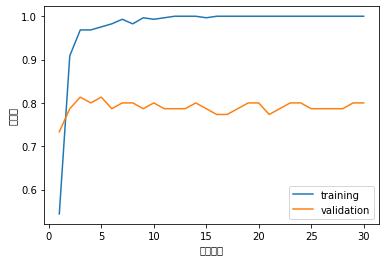

In [25]:
plt.plot(range(1, 30+1),word_result_all['accuracy'] , label="training")
plt.plot(range(1, 30+1), word_result_all['val_accuracy'], label="validation")
plt.xlabel('学習回数')
plt.ylabel('正解率')
plt.legend()
plt.show()

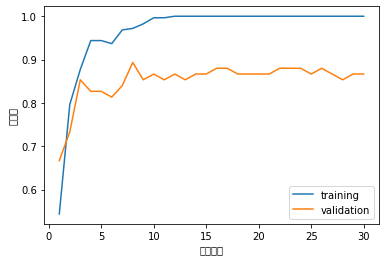

In [26]:
plt.plot(range(1, 30+1),doc_result_all['accuracy'] , label="training")
plt.plot(range(1, 30+1), doc_result_all['val_accuracy'], label="validation")
plt.xlabel('学習回数')
plt.ylabel('正解率')
plt.legend()
plt.show()

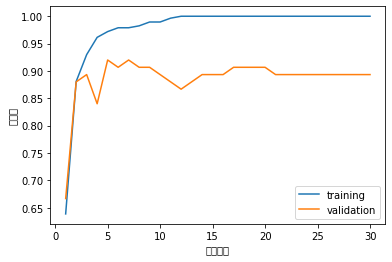

In [27]:
plt.plot(range(1, 30+1),bert_result_all['accuracy'] , label="training")
plt.plot(range(1, 30+1),bert_result_all['val_accuracy'], label="validation")
plt.xlabel('学習回数')
plt.ylabel('正解率')
plt.legend()
plt.show()

In [28]:
max(word_result_all['val_accuracy'])

0.8133333444595336

In [29]:
max(doc_result_all['val_accuracy'])

0.8933333396911621

In [30]:
max(bert_result_all['val_accuracy'])

0.9200000047683716

# hopを考える